In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier


In [ ]:
df = pd.read_csv("malicious_dataset_with_10000_benign.csv")

In [ ]:
# Hatalı satırı çıkar (type isimli satır)
df = df[df["type"] != "type"]

# Etiketlerdeki boşlukları sil (garanti olsun)
df["type"] = df["type"].str.strip()

# Binary etiketleme: benign → 0, diğerleri → 1
df["label"] = df["type"].apply(lambda x: 0 if x == "benign" else 1)


KeyError: 'type'

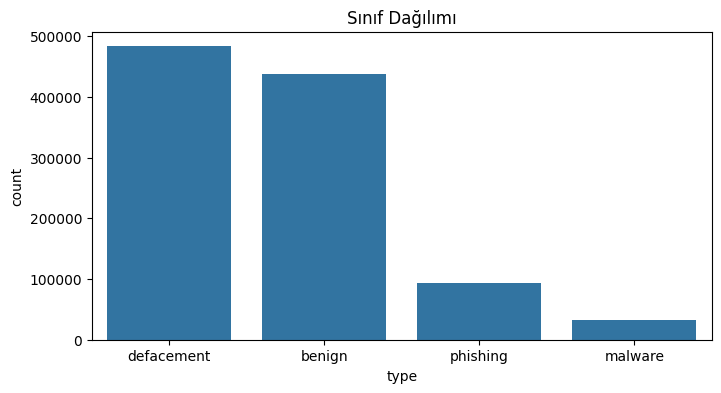

type
defacement    483329
benign        437883
phishing       93814
malware        32520
Name: count, dtype: int64


In [ ]:
plt.figure(figsize=(8, 4))
sns.countplot(data=df, x="type", order=df["type"].value_counts().index)
plt.title("Sınıf Dağılımı")
plt.show()

print(df["type"].value_counts())


In [ ]:
# benign -> 0 (güvenli), diğerleri -> 1 (zararlı)
df["label"] = df["type"].apply(lambda x: 0 if x == "benign" else 1)


KeyError: 'type'

In [ ]:
X = df["url"]
y = df["label"]


In [ ]:
vectorizer = TfidfVectorizer(
    max_features=10000,  # maksimum kelime sayısı
    min_df=5,            # en az 5 farklı URL'de geçenler
    max_df=0.8,          # %80'den fazla URL'de geçenleri dışla
    token_pattern=r'[a-zA-Z0-9]{2,}'  # küçük kelimeleri çıkar
)
X_vect = vectorizer.fit_transform(X)



In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X_vect, y, test_size=0.2, random_state=42, stratify=y
)


In [ ]:
model = XGBClassifier(
    tree_method="gpu_hist",  # GPU varsa
    use_label_encoder=False,
    eval_metric="logloss",
    random_state=42,
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    scale_pos_weight=(y == 0).sum() / (y == 1).sum()  # sınıf dengesizliği için
)
model.fit(X_train, y_train)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:26:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:26:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [ ]:
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 0.5418261658154742

Classification Report:
               precision    recall  f1-score   support

           0       0.46      0.54      0.50     87577
           1       0.62      0.54      0.58    121933

    accuracy                           0.54    209510
   macro avg       0.54      0.54      0.54    209510
weighted avg       0.55      0.54      0.54    209510


Confusion Matrix:
 [[47419 40158]
 [55834 66099]]


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:26:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:26:46] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


In [ ]:
#Özellik çıkarma işlemi
def extract_features(df):
    df_feat = pd.DataFrame()
    df_feat["url_length"] = df["url"].apply(len)
    df_feat["num_digits"] = df["url"].str.count(r'\d')
    df_feat["num_special_chars"] = df["url"].str.count(r'[^\w]')
    df_feat["has_https"] = df["url"].str.contains("https").astype(int)
    df_feat["num_subdomains"] = df["url"].str.count(r'\.')
    return df_feat


In [ ]:
from scipy.sparse import hstack

X_tfidf = vectorizer.fit_transform(X)
X_extra = extract_features(df)
X_combined = hstack([X_tfidf, X_extra.values])


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X_combined, y, test_size=0.2, random_state=42, stratify=y
)


In [ ]:
model = XGBClassifier(
    tree_method="gpu_hist",
    use_label_encoder=False,
    eval_metric="logloss",
    n_estimators=300,
    max_depth=8,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=(y == 0).sum() / (y == 1).sum(),
    random_state=42
)
model.fit(X_train, y_train)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:27:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:27:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [ ]:
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:27:51] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Accuracy: 0.9001097799627703

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.89      0.88     87577
           1       0.92      0.91      0.91    121933

    accuracy                           0.90    209510
   macro avg       0.90      0.90      0.90    209510
weighted avg       0.90      0.90      0.90    209510


Confusion Matrix:
 [[ 77886   9691]
 [ 11237 110696]]


In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))


KeyboardInterrupt: 

In [ ]:
import joblib

# Modeli ve TF-IDF + ekstra özellik çıkarıcıyı kaydet
joblib.dump(model, "xgb_url_model.pkl")
joblib.dump(vectorizer, "tfidf_vectorizer.pkl")
joblib.dump(X_extra.columns.tolist(), "extra_feature_names.pkl")


['extra_feature_names.pkl']

In [ ]:
!pip install gradio


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.2/54.2 MB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.1/323.1 kB 29.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 132.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 6.8 MB/s eta 0:00:00


In [ ]:
import gradio as gr
import joblib
import re
import pandas as pd
from scipy.sparse import hstack

# Model ve vektörleri yükle
model = joblib.load("xgb_url_model.pkl")
vectorizer = joblib.load("tfidf_vectorizer.pkl")
extra_features = joblib.load("extra_feature_names.pkl")

# Özellik çıkarımı
def extract_features_from_url(url):
    return pd.DataFrame([{
        "url_length": len(url),
        "num_digits": len(re.findall(r'\d', url)),
        "num_special_chars": len(re.findall(r'[^\w]', url)),
        "has_https": int("https" in url),
        "num_subdomains": url.count('.')
    }])[extra_features]

# Tahmin fonksiyonu
def predict_url_with_proba(url):
    # TF-IDF + ekstra özellikleri birleştir
    url_tfidf = vectorizer.transform([url])
    url_extra = extract_features_from_url(url)
    combined_features = hstack([url_tfidf, url_extra.values])

    # Tahmin ve olasılık
    prediction = model.predict(combined_features)[0]
    probability = model.predict_proba(combined_features)[0][prediction]

    label = "✅ Güvenli (Benign)" if prediction == 0 else "🚨 Zararlı (Malicious)"
    confidence = f"%{round(probability * 100, 2)} güven"

    return f"{label} - {confidence}"

In [ ]:
gr.Interface(
    fn=predict_url_with_proba,
    inputs=gr.Textbox(label="URL'yi girin"),
    outputs=gr.Textbox(label="Tahmin Sonucu"),
    title="🔐 URL Güvenlik Tahmin Aracı",
    description="URL'yi analiz eder ve güvenli (benign) mi yoksa zararlı (malicious) mı olduğunu tahmin eder. Doğruluk oranı ile birlikte sonuç verir.",
    theme="default"
).launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://961c3d901a13e41916.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


<ipython-input-21-3b4eb836ecb9>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="type", order=df["type"].value_counts().index, palette="viridis")


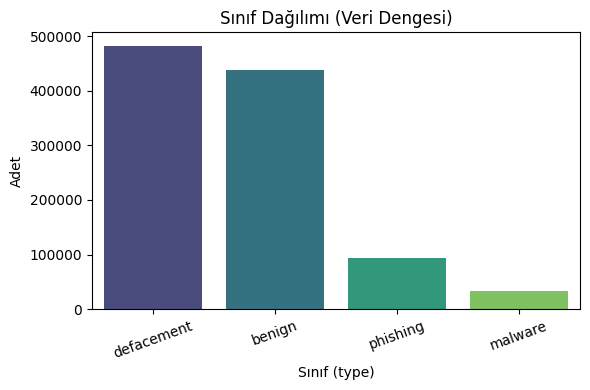

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 4))
sns.countplot(data=df, x="type", order=df["type"].value_counts().index, palette="viridis")
plt.title("Sınıf Dağılımı (Veri Dengesi)")
plt.xlabel("Sınıf (type)")
plt.ylabel("Adet")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()


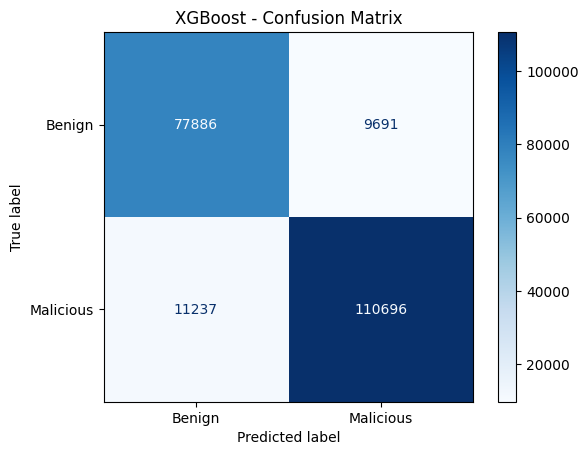

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Benign", "Malicious"])
disp.plot(cmap="Blues")
plt.title("XGBoost - Confusion Matrix")
plt.show()


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:06:41] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


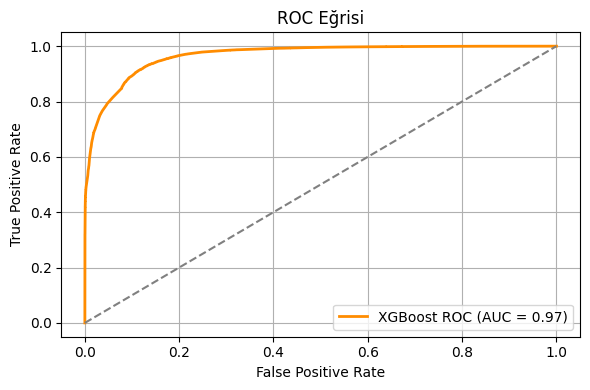

In [ ]:
from sklearn.metrics import roc_curve, auc

y_prob = model.predict_proba(X_test)[:, 1]  # XGBoost için
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'XGBoost ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Eğrisi')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np

feature_names = vectorizer.get_feature_names_out()
importances = model.feature_importances_

# Sıfır olmayan önem skorlarına göre filtrele
nonzero_indices = np.where(importances > 0)[0]
top_n = min(20, len(nonzero_indices))  # Elimizde en az 20 özellik yoksa hata verme

# En önemli N özelliği seç
sorted_indices = np.argsort(importances[nonzero_indices])[-top_n:]
selected_indices = nonzero_indices[sorted_indices]


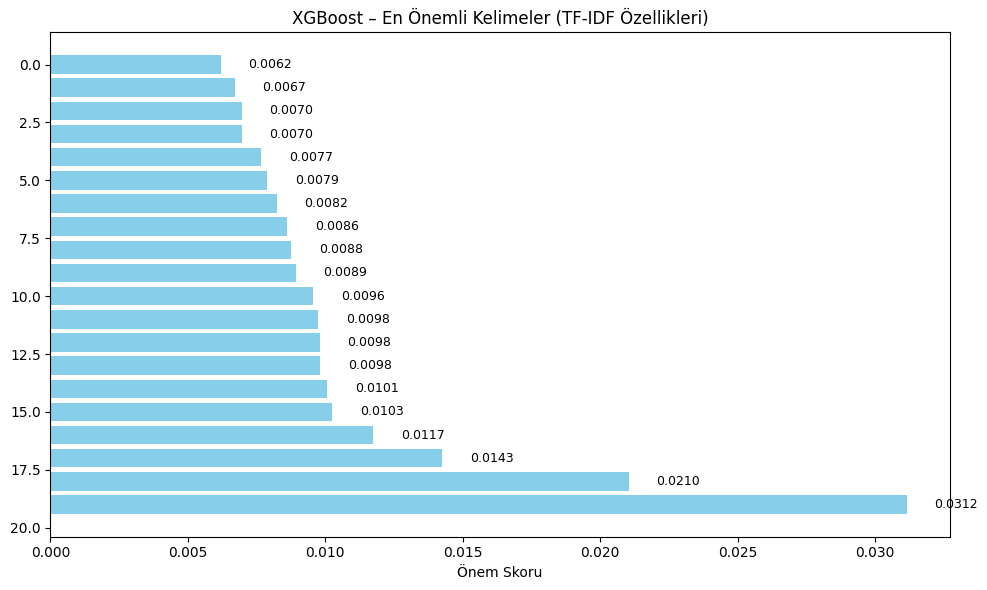

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
bars = plt.barh(range(top_n), importances[selected_indices], align="center", color="skyblue")



# X ekseni başlık
plt.xlabel("Önem Skoru")
plt.title("XGBoost – En Önemli Kelimeler (TF-IDF Özellikleri)")

# Her barın sağına değerini yaz
for i, bar in enumerate(bars):
    score = importances[selected_indices[i]]
    plt.text(score + 0.001, i, f"{score:.4f}", va='center', fontsize=9)

plt.gca().invert_yaxis()  # En önemli kelime en üstte görünsün
plt.tight_layout()
plt.show()


<ipython-input-26-0d9a94f7d110>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=x, y=y_scores, palette="Set2")


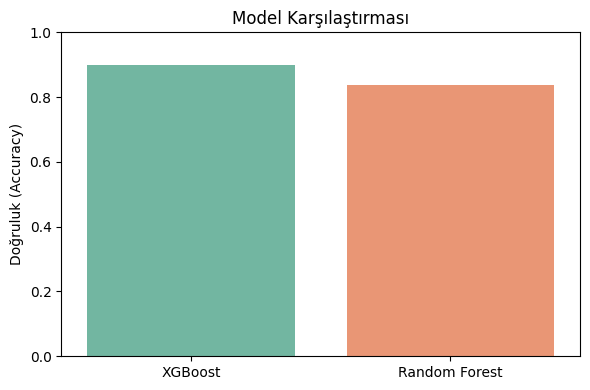

In [ ]:
x = ["XGBoost", "Random Forest"]
y_scores = [
    accuracy_score(y_test, y_pred),
    accuracy_score(y_test, y_pred_rf)
]

plt.figure(figsize=(6, 4))
sns.barplot(x=x, y=y_scores, palette="Set2")
plt.ylim(0, 1)
plt.ylabel("Doğruluk (Accuracy)")
plt.title("Model Karşılaştırması")
plt.tight_layout()
plt.show()


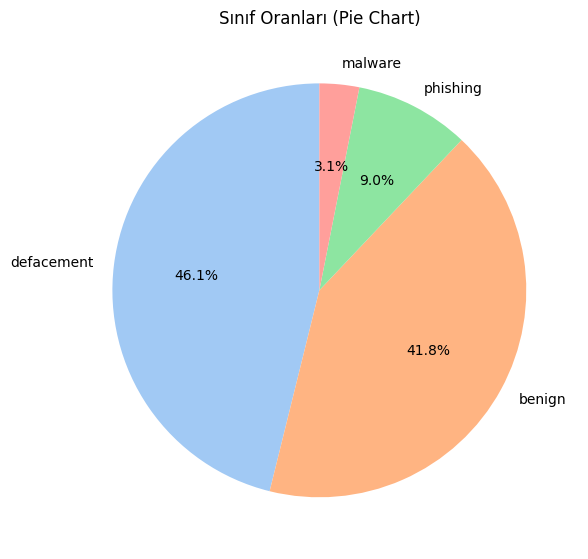

In [ ]:
plt.figure(figsize=(6, 6))
df["type"].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, colors=sns.color_palette('pastel'))
plt.title("Sınıf Oranları (Pie Chart)")
plt.ylabel("")
plt.tight_layout()
plt.show()


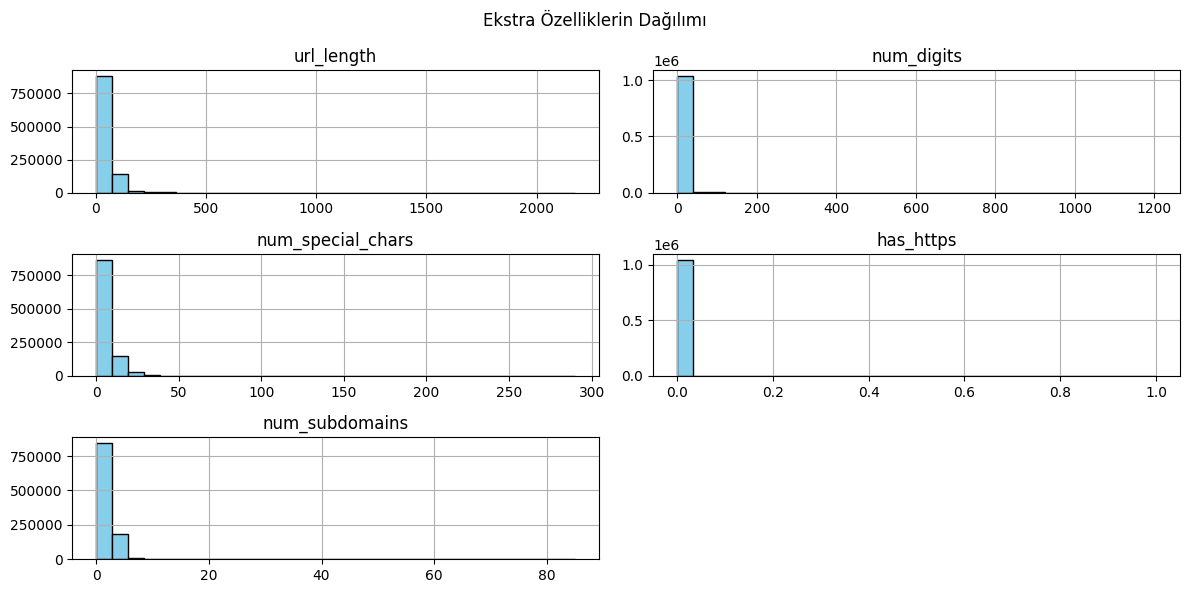

In [ ]:
features = extract_features(df)
features.hist(figsize=(12, 6), bins=30, color='skyblue', edgecolor='black')
plt.suptitle("Ekstra Özelliklerin Dağılımı")
plt.tight_layout()
plt.show()


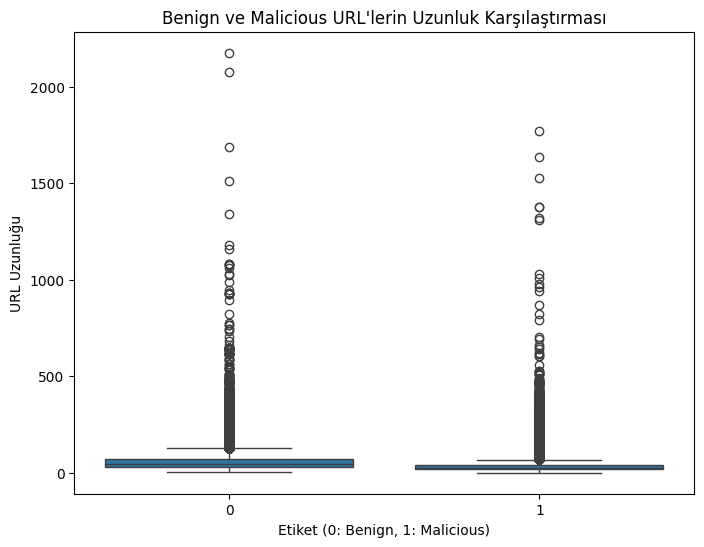

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

features["label"] = df["label"]
plt.figure(figsize=(8, 6))
sns.boxplot(x="label", y="url_length", data=features)
plt.title("Benign ve Malicious URL'lerin Uzunluk Karşılaştırması")
plt.xlabel("Etiket (0: Benign, 1: Malicious)")
plt.ylabel("URL Uzunluğu")
plt.show()


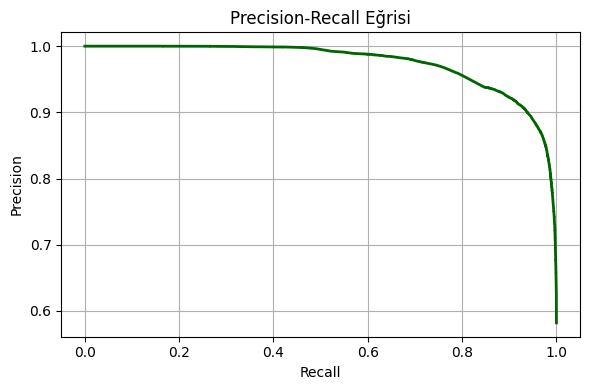

In [ ]:
from sklearn.metrics import precision_recall_curve

precision, recall, _ = precision_recall_curve(y_test, y_prob)
plt.figure(figsize=(6, 4))
plt.plot(recall, precision, color='darkgreen', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Eğrisi')
plt.grid(True)
plt.tight_layout()
plt.show()


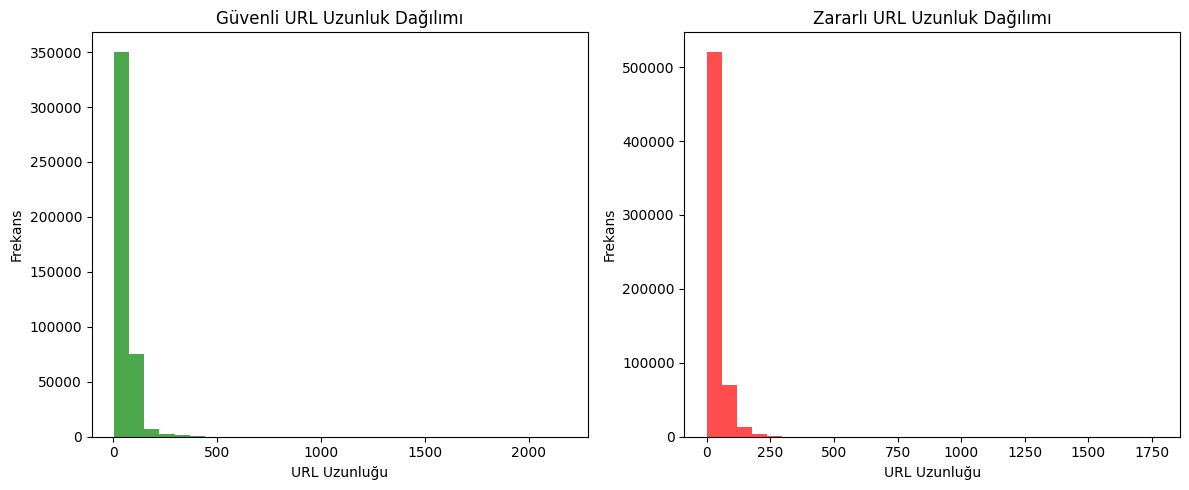

In [ ]:
import matplotlib.pyplot as plt

# Özellik çıkarma fonksiyonunu kullanarak özellikleri çıkaralım
features = extract_features(df)

# Label bilgisi
labels = df["label"]

# Güvenli URL'lerin uzunlukları
benign_lengths = features["url_length"][labels == 0]

# Zararlı URL'lerin uzunlukları
malicious_lengths = features["url_length"][labels == 1]

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(benign_lengths, bins=30, color='green', alpha=0.7)
plt.title("Güvenli URL Uzunluk Dağılımı")
plt.xlabel("URL Uzunluğu")
plt.ylabel("Frekans")

plt.subplot(1, 2, 2)
plt.hist(malicious_lengths, bins=30, color='red', alpha=0.7)
plt.title("Zararlı URL Uzunluk Dağılımı")
plt.xlabel("URL Uzunluğu")
plt.ylabel("Frekans")

plt.tight_layout()
plt.show()


<ipython-input-32-f2b363a73d57>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df["label"], y=features["url_length"], palette=["green", "red"])


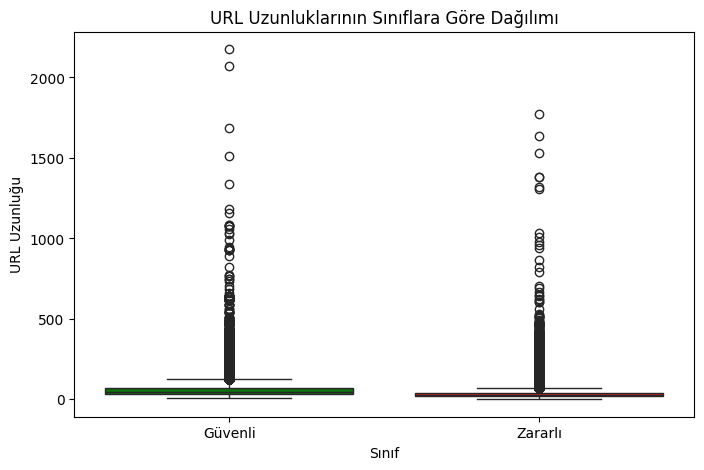

In [ ]:
plt.figure(figsize=(8, 5))
sns.boxplot(x=df["label"], y=features["url_length"], palette=["green", "red"])
plt.xticks([0, 1], ["Güvenli", "Zararlı"])
plt.title("URL Uzunluklarının Sınıflara Göre Dağılımı")
plt.xlabel("Sınıf")
plt.ylabel("URL Uzunluğu")
plt.show()


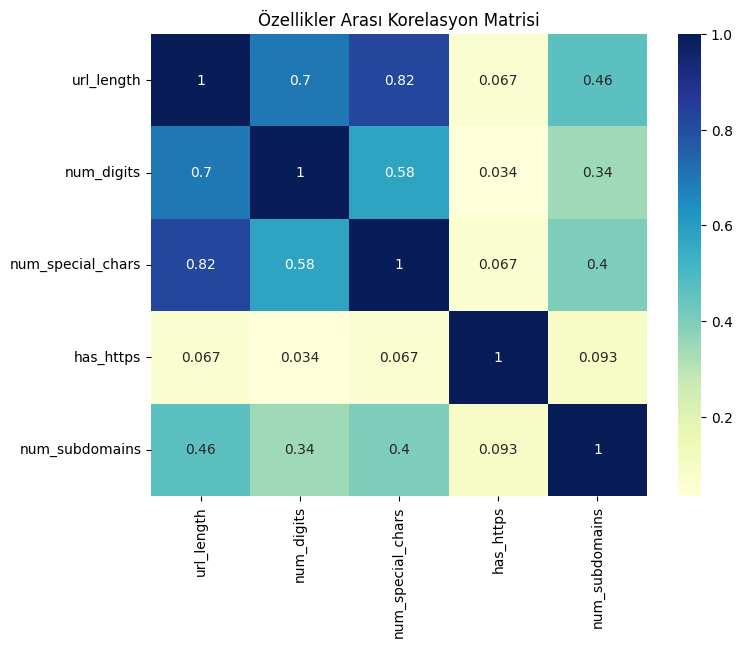

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(features.corr(), annot=True, cmap="YlGnBu")
plt.title("Özellikler Arası Korelasyon Matrisi")
plt.show()


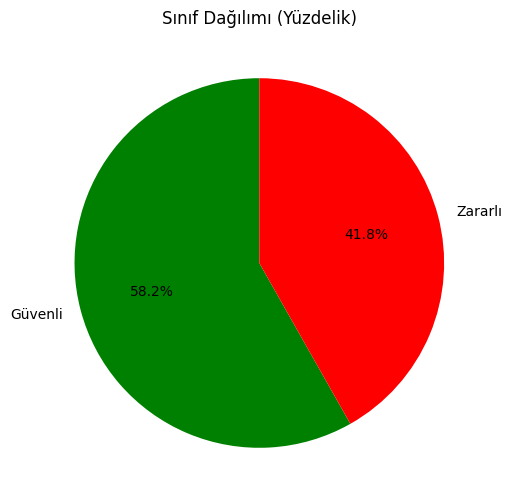

In [ ]:
plt.figure(figsize=(6, 6))
df["label"].value_counts().plot.pie(
    labels=["Güvenli", "Zararlı"],
    autopct="%1.1f%%",
    startangle=90,
    colors=["green", "red"]
)
plt.title("Sınıf Dağılımı (Yüzdelik)")
plt.ylabel("")
plt.show()


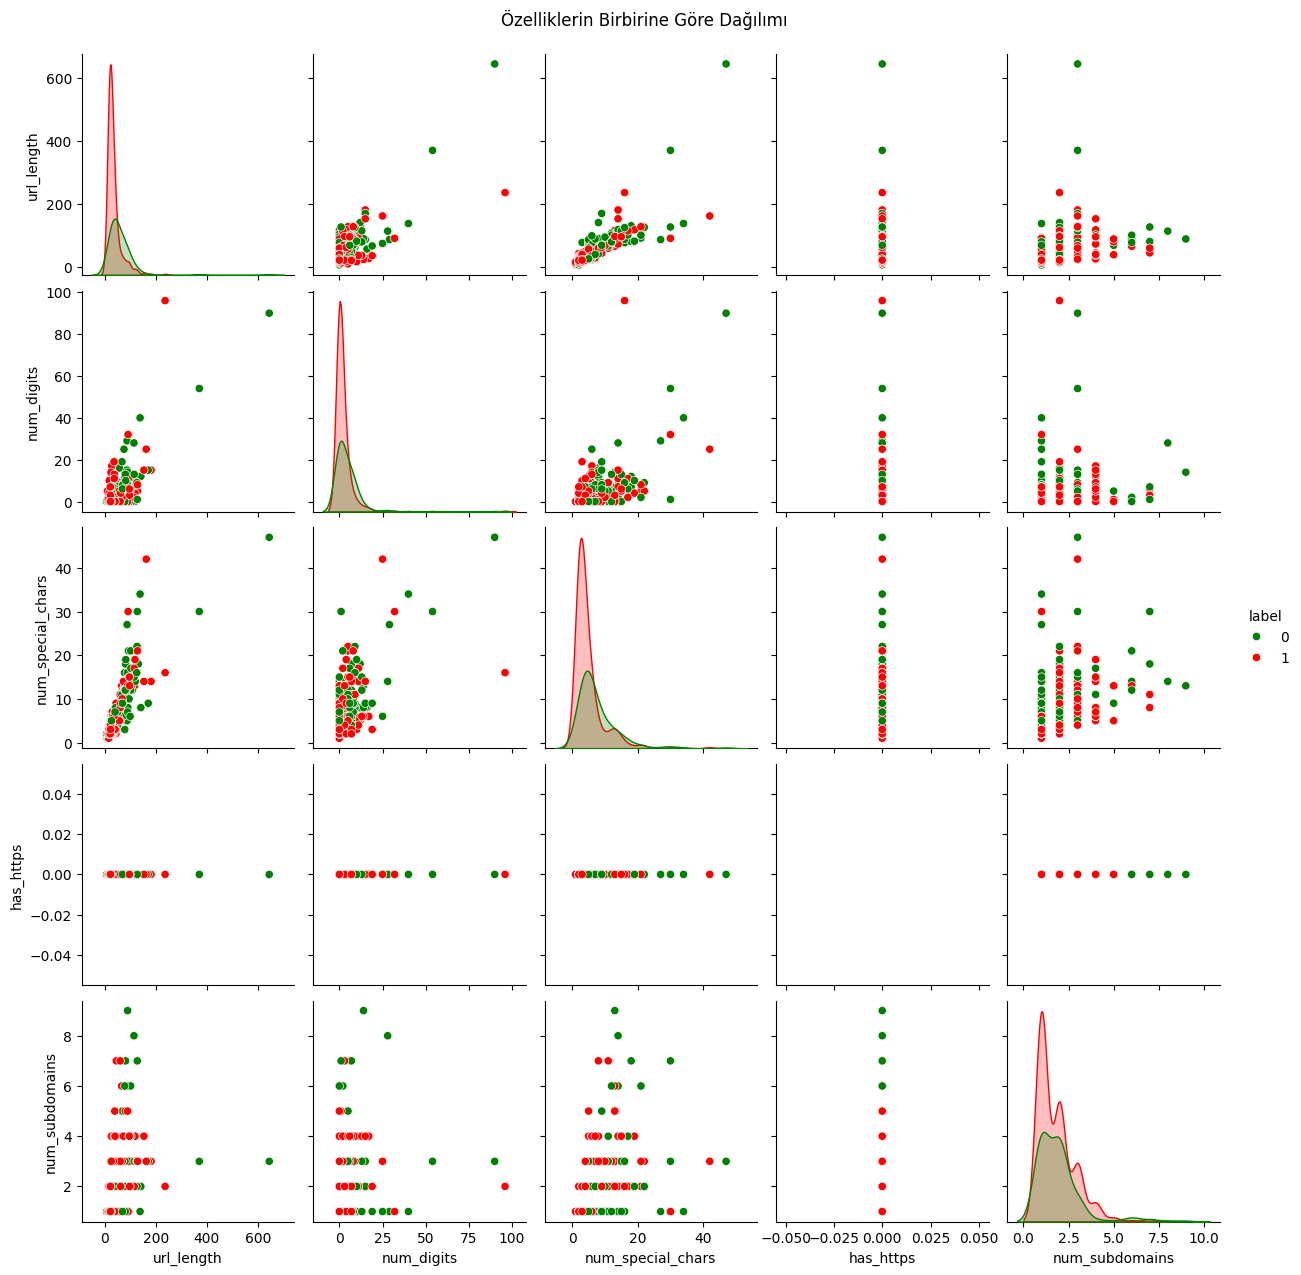

In [ ]:
import warnings
warnings.filterwarnings("ignore")

all_features = extract_features(df)
all_features["label"] = df["label"]

sns.pairplot(all_features.sample(500), hue="label", palette=["green", "red"])
plt.suptitle("Özelliklerin Birbirine Göre Dağılımı", y=1.02)
plt.show()


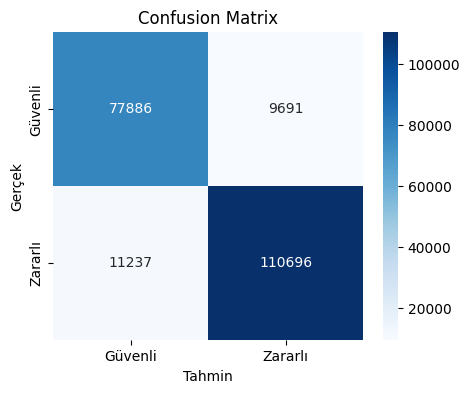

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Güvenli", "Zararlı"], yticklabels=["Güvenli", "Zararlı"])
plt.title("Confusion Matrix")
plt.xlabel("Tahmin")
plt.ylabel("Gerçek")
plt.show()
